In [1]:
# load some libraries
import sys
import os
import pickle
import gzip
sys.path.insert(1, '..')
os.chdir('..')

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import darts
from darts import metrics

from lib.gluformer.model import *
from lib.latent_ode.trainer_glunet import *
from utils.darts_processing import *
from utils.darts_dataset import *

# Glucose plots

In [2]:
# plots of uninterpolated glucose data for each patient
# for plots showing splitting and interpolation, in winstock config file gap_threshold: 5, min_drop_length: 50
formatter, series, scalers = load_data(seed=0, study_file=None, dataset='weinstock', use_covs=True, use_static_covs=True)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...
Dropping columns / rows...
Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		Height: REAL_VALUED (STATIC_INPUT)
		Weight: REAL_VALUED (STATIC_INPUT)
		Gender: REAL_VALUED (STATIC_INPUT)
		Race: REAL_VALUED (STATIC_INPUT)
		EduLevel: REAL_VALUED (STATIC_INPUT)
		AnnualInc: REAL_VALUED (STATIC_INPUT)
		MaritalStatus: REAL_VALUED (STATIC_INPUT)
		DaysWkEx: REAL_VALUED (STATIC_INPUT)
		DaysWkDrinkAlc: REAL_VALUED (STATIC_INPUT)
		DaysMonBingeAlc: REAL_VALUED (STATIC_INPUT)
		T1DDiagAge: REAL_VALUED (STATIC_INPUT)
		NumHospDKA: REAL_VALUED (STATIC_INPUT)
		NumSHSinceT1DDiag: REAL_VALUED (STATIC_INPUT)
		InsDeliveryMethod: REAL_VALUED (STATIC_INPUT)
		UnitsInsTotal: REAL_VALUED (STATIC_INPUT)
		NumMeterCheckDay: REAL_VALUED (STATIC_INPUT)
		Aspir

In [3]:
# extract data to plot: patients with more than 3 segments
plot_data = []
for pateint_id, patient_data in formatter.data.groupby('id'):
    # count number of unique segments, id_segment
    n_segment = patient_data['id_segment'].nunique()
    if n_segment > 3:
        plot_data.append(patient_data)
        if len(plot_data) == 3:
            break
# for each patient, create a column with number of minutes since the absolute start
#    and convert to long format for plotting
for i, patient_data in enumerate(plot_data):
    patient_data['time'] = patient_data['time'] - patient_data['time'].min()
    # convert time to float, number of hours
    patient_data['time'] = patient_data['time'].dt.total_seconds() / 3600
    # convert to long format for plotting
    plot_data[i] = patient_data.melt(id_vars=['time', 'id_segment'], value_vars=['gl'], 
                                     var_name='y', value_name='x')

/Users/varogovchenko/miniconda3/envs/projenv371/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: 
The palette list has fewer values (7) than needed (24) and will cycle, which may produce an uninterpretable plot.
  if __name__ == "__main__":
/Users/varogovchenko/miniconda3/envs/projenv371/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: 
The palette list has fewer values (7) than needed (19) and will cycle, which may produce an uninterpretable plot.
  if __name__ == "__main__":
/Users/varogovchenko/miniconda3/envs/projenv371/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: 
The palette list has fewer values (7) than needed (24) and will cycle, which may produce an uninterpretable plot.
  if __name__ == "__main__":


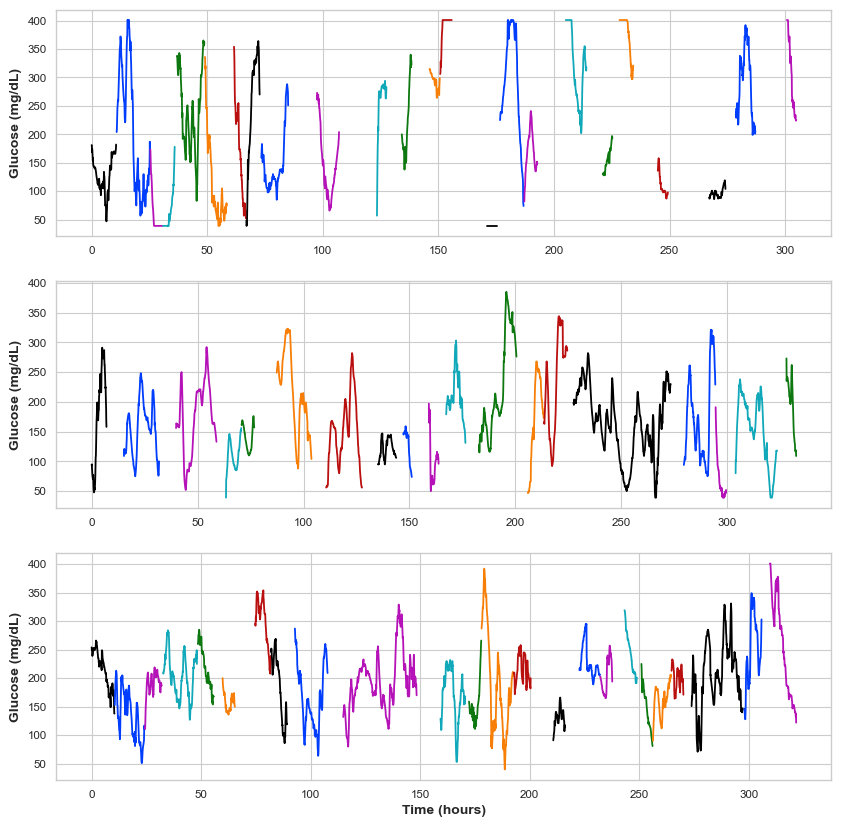

In [4]:
# use whitegrid style
sns.set_style('whitegrid')
colors = ['#000000', '#003DFD', '#b512b8', '#11a9ba', '#0d780f', '#f77f07', '#ba0f0f']
# plot using seaborn
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
for i, patient_data in enumerate(plot_data):
    sns.lineplot(x='time', y='x', hue='id_segment', 
                 data=patient_data, ax=axes[i],
                 palette=colors)
    axes[i].set_ylabel('Glucose (mg/dL)')
    # remove legend
    axes[i].get_legend().remove()
    # only add xlabel to last plot
    axes[i].set_xlabel('')
    if i == 2:
        axes[i].set_xlabel('Time (hours)')

# Split and interpolation example plots

In [5]:
# get ids from the data
ids = []
for i in range(len(series['train']['target'])):
    ids.append(series['train']['target'][i].static_covariates['id'][0])
# make a table of ids and how many of each id there are
ids_table = {id: 0 for id in ids}
for id in ids:
    ids_table[id] += 1
# select ids with most number of components
ids = [id for id in ids_table if ids_table[id] > 5]
# extract glucose data for each id
id_series = {id: [] for id in ids}
for i in range(len(series['train']['target'])):
    for id in ids:
        if np.isclose(series['train']['target'][i].static_covariates['id'][0], id):
            id_series[id].append(series['train']['target'][i])
# inverse scale glucose data
for id in ids:
    id_series[id] = scalers['target'].inverse_transform(id_series[id])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


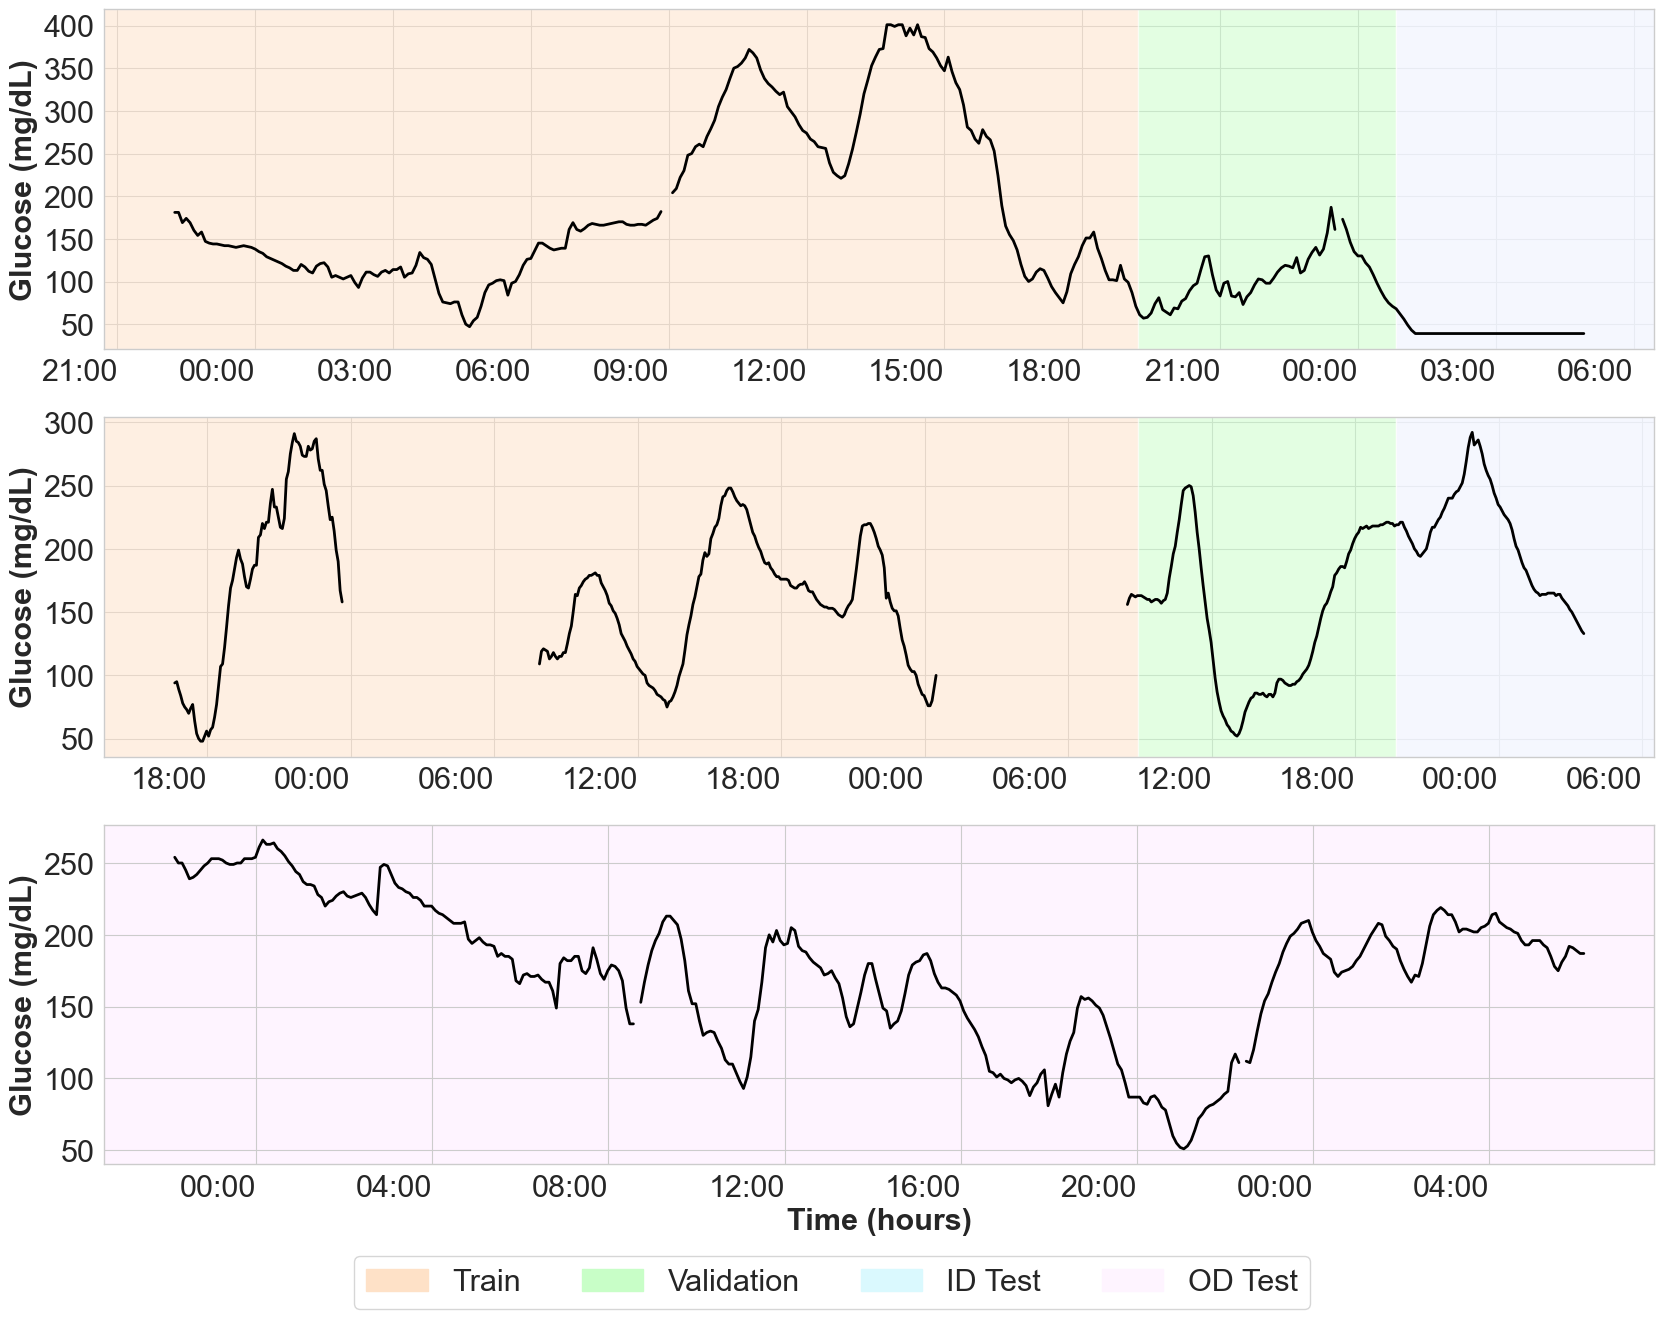

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

# Define the colors for the rectangles
colors = ['#FEE1C7', '#C8FEC7', '#DAF9FE', '#FEF4FF']
labels = ['Train', 'Validation', 'ID Test', 'OD Test']

# plot glucose data for each id
fig, axs = plt.subplots(3, 1, figsize=(20, 15))
for i, id in enumerate(ids[:3]):
    for j in range(len(id_series[id][:3])):
        # Set the line color to black and remove the label
        id_series[id][j].plot(ax=axs[i], color='black', label='')  

    axs[i].legend().set_visible(False)  # Remove the legend after plotting the data

    if i < len(ids[:3]) - 1:  # Only create rectangles for the first two plots
        y_min, y_max = axs[i].get_ylim()
        x_min, x_max = axs[i].get_xlim()
        total_width = x_max - x_min
        first_width = total_width * 2/3
        second_width = (total_width - first_width) / 2

        for k, color in enumerate(colors):
            if k == 0:
                width = first_width
            else:
                width = second_width
            rect = Rectangle((x_min + sum(width for width in [first_width, second_width][:k]), y_min),
                             width, y_max - y_min, facecolor=color, alpha=0.5)
            axs[i].add_patch(rect)
    else:  # Set the background color of the last plot to #D6EDFE
        axs[i].set_facecolor('#FEF4FF')
        axs[i].set_xlabel('Time (hours)')  # Add x axis label to the third plot

    axs[i].set_ylabel('Glucose (mg/dL)')
    axs[i].set_title('')
    axs[i].tick_params(axis='x', rotation=0)

    # Display hours and minutes on the x-axis
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # increase font size
    for item in ([axs[i].xaxis.label, axs[i].yaxis.label] +
                axs[i].get_xticklabels() + axs[i].get_yticklabels()):
        item.set_fontsize(22)
        if i == 2:
            axs[i].xaxis.label.set_visible(True)  # Add x axis label only to the third plot
        else:
            axs[i].xaxis.label.set_visible(False)  # Hide x axis label for the first two plots
            
# Create a custom legend for the colors
legend_elements = [Rectangle((0, 0), 1, 1, facecolor=color, edgecolor=color, label=label)
                   for color, label in zip(colors, labels)]
fig.legend(handles=legend_elements, loc='lower center', ncol=len(colors), fontsize=22, frameon=True)

# save as pdf with transparent background
plt.savefig('presentation/plots/glucose_data_split_plot.pdf', bbox_inches='tight', transparent=False)

On the plot below choose just two representative ids for the paper

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


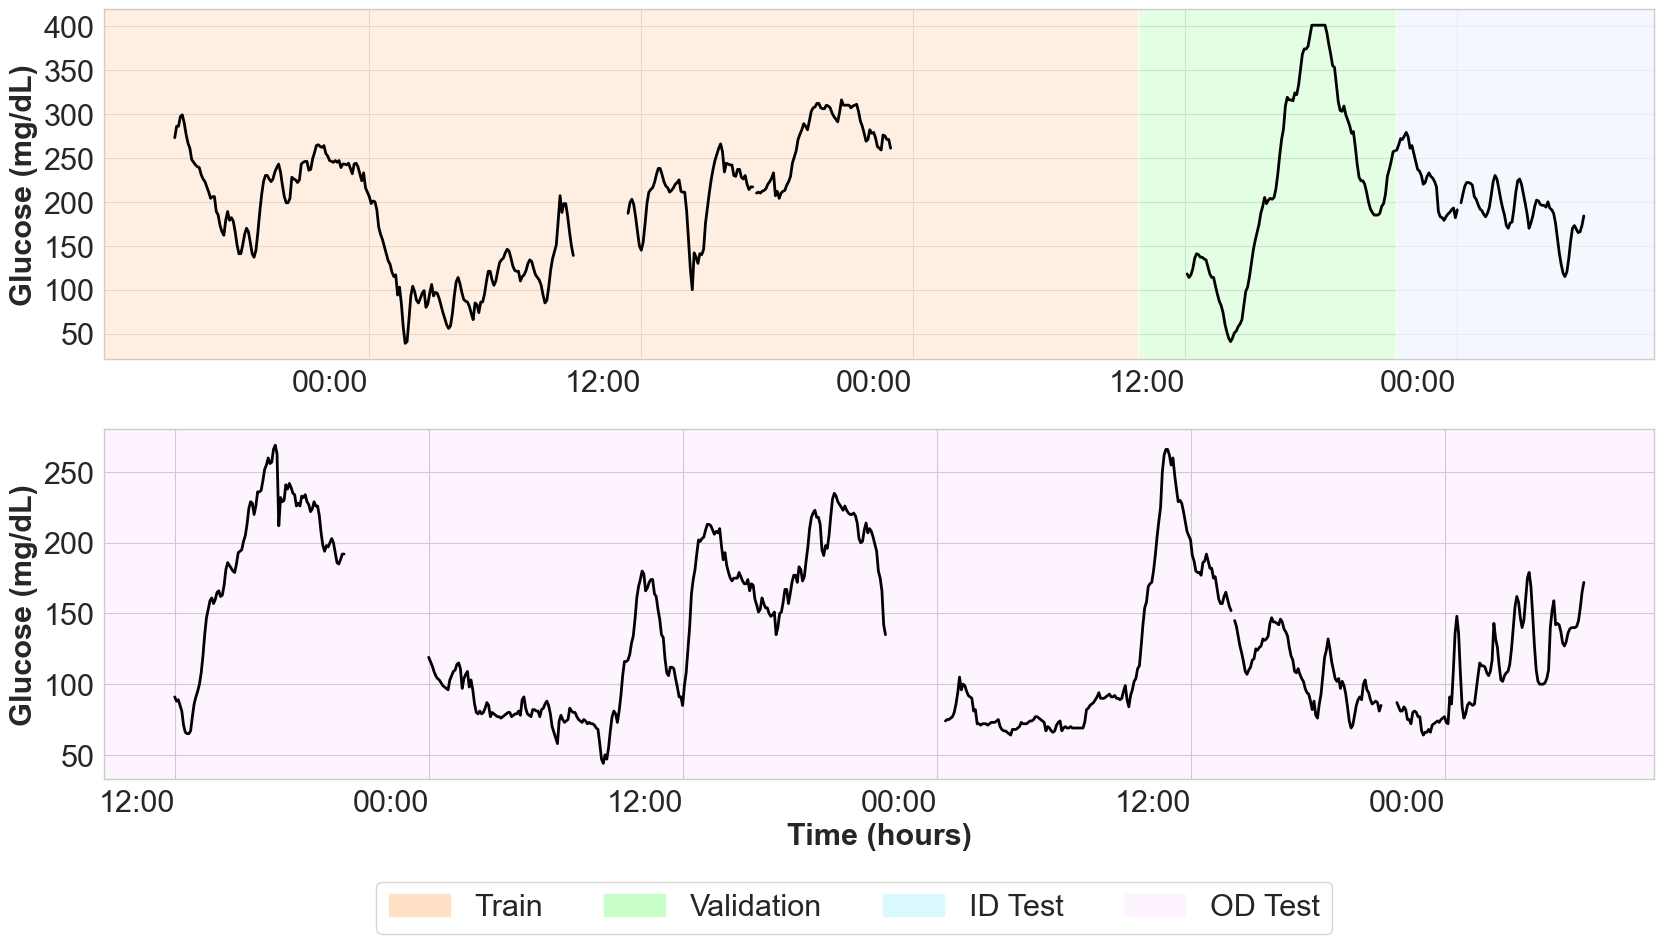

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

# Define the colors for the rectangles
colors = ['#FEE1C7', '#C8FEC7', '#DAF9FE', '#FEF4FF']
labels = ['Train', 'Validation', 'ID Test', 'OD Test']

# plot glucose data for each id
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

# Modify the loop to only iterate through the subjects you want
subject_indices = [26,14]  

for ax_idx, id_idx in enumerate(subject_indices):
    id = ids[id_idx]
    for j in range(len(id_series[id][:5])):
        # Set the line color to black and remove the label
        id_series[id][j].plot(ax=axs[ax_idx], color='black', label='') 

    axs[ax_idx].legend().set_visible(False)  # Remove the legend after plotting the data

    if ax_idx == 0:  # Only create rectangles for the first plot
        y_min, y_max = axs[ax_idx].get_ylim()
        x_min, x_max = axs[ax_idx].get_xlim()
        total_width = x_max - x_min
        first_width = total_width * 2/3
        second_width = (total_width - first_width) / 2

        for k, color in enumerate(colors):
            if k == 0:
                width = first_width
            else:
                width = second_width
            rect = Rectangle((x_min + sum(width for width in [first_width, second_width][:k]), y_min),
                             width, y_max - y_min, facecolor=color, alpha=0.5)
            axs[ax_idx].add_patch(rect)
    else:  # Set the background color of the last plot to #D6EDFE
        axs[ax_idx].set_facecolor('#FEF4FF')
        axs[ax_idx].set_xlabel('Time (hours)')  # Add x axis label to the third plot

    axs[ax_idx].set_ylabel('Glucose (mg/dL)')
    axs[ax_idx].set_title('')
    axs[ax_idx].tick_params(axis='x', rotation=0)

    # Display hours and minutes on the x-axis
    axs[ax_idx].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # increase font size
    for item in ([axs[ax_idx].xaxis.label, axs[ax_idx].yaxis.label] +
                axs[ax_idx].get_xticklabels() + axs[ax_idx].get_yticklabels()):
        item.set_fontsize(22)
        if ax_idx == 1:
            axs[ax_idx].xaxis.label.set_visible(True)  # Add x axis label only to the third plot
        else:
            axs[ax_idx].xaxis.label.set_visible(False)  # Hide x axis label for the first two plots
            
# Create a custom legend for the colors
legend_elements = [Rectangle((0, 0), 1, 1, facecolor=color, edgecolor=color, label=label)
                   for color, label in zip(colors, labels)]
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.06), ncol=len(colors), fontsize=22, frameon=True)

# save as pdf with transparent background
plt.savefig('paper_results/plots/glucose_data_split_plot.pdf', bbox_inches='tight', transparent=False)

# Example plots of other Timeseries

In [ ]:
# load electrcity data 
from darts.datasets import TemperatureDataset
from darts.datasets import AirPassengersDataset
from darts.datasets import HeartRateDataset

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(30, 15))
dataset_names = ['Temperature', 'AirPassengers', 'HeartRate']
yaxis = ['Temperature (C)', 'AirPassengers', 'HeartRate (bpm)']
for i, dataset in enumerate([TemperatureDataset(), AirPassengersDataset(), HeartRateDataset()]):
    dataset.load().plot(ax=axs[i])
    axs[i].set_ylabel(f'{yaxis[i]}')
    axs[i].set_xlabel('')
    axs[i].tick_params(axis='x', rotation=0)
    axs[i].set_title(f'{dataset_names[i]}')
    if axs[i].get_legend() is not None:
        axs[i].get_legend().remove()
    # increase font size
    for item in ([axs[i].title, axs[i].xaxis.label, axs[i].yaxis.label] +
                axs[i].get_xticklabels() + axs[i].get_yticklabels()):
        item.set_fontsize(22)
# save as pdf
plt.savefig('presentation/plots/ts_data.pdf', bbox_inches='tight')

# Save forecasts of all models: no covariates, ID test

In [ ]:
# model params
model_params = {'transformer': {'darts': models.TransformerModel, 'darts_data': SamplingDatasetInferencePast, 'use_covs': False, 'use_static_covs': False, 'cov_type': 'past'},
                'nhits': {'darts': models.NHiTSModel, 'darts_data': SamplingDatasetInferencePast, 'use_covs': False, 'use_static_covs': False, 'cov_type': 'past'},
                'tft': {'darts': models.TFTModel, 'darts_data': SamplingDatasetInferenceMixed, 'use_covs': False, 'use_static_covs': True, 'cov_type': 'mixed'},
                'xgboost': {'darts': models.XGBModel, 'use_covs': False, 'use_static_covs': False, 'cov_type': 'past'},
                'linreg': {'darts': models.LinearRegressionModel, 'use_covs': False, 'use_static_covs': False, 'cov_type': 'past'}}
# data sets
datasets = ['weinstock', 'dubosson', 'colas', 'iglu', 'hall']
save_trues = {}
save_forecasts = {}
save_inputs = {}
# iterate through models and datasets
for model_name in model_params.keys():
    for dataset in datasets:
        print(f'Testing {model_name} for {dataset}')
        formatter, series, scalers = load_data(seed=0, study_file=None, dataset=dataset, 
                                               use_covs=model_params[model_name]['use_covs'], 
                                             use_static_covs=model_params[model_name]['use_static_covs'],
                                             cov_type=model_params[model_name]['cov_type'])
        # load model or refit model
        if model_name in ['tft', 'transformer', 'nhits']:
            # load model: transformer
            model = model_params[model_name]['darts'](input_chunk_length=formatter.params[model_name]['in_len'],
                                              output_chunk_length=formatter.params['length_pred'])
            model = model.load_from_checkpoint(f'tensorboard_{model_name}_{dataset}', work_dir = './output', best=True)
            # define dataset for inference
            test_dataset = model_params[model_name]['darts_data'](target_series=series['test']['target'],
                                                              n=formatter.params['length_pred'],
                                                                input_chunk_length=formatter.params[model_name]['in_len'],
                                                                  output_chunk_length=formatter.params['length_pred'],
                                                                  use_static_covariates=model_params[model_name]['use_static_covs'],
                                                                  max_samples_per_ts = None)
            # get predictions
            forecasts = model.predict_from_dataset(n=formatter.params['length_pred'], 
                                                   input_series_dataset=test_dataset,
                                                   verbose=True,
                                                   num_samples=20 if model_name == 'tft' else 1)
            forecasts = scalers['target'].inverse_transform(forecasts)
            save_forecasts[f'{model_name}_{dataset}'] = forecasts
            # get true values
            save_trues[f'{model_name}_{dataset}'] = [test_dataset.evalsample(i) for i in range(len(test_dataset))]
            save_trues[f'{model_name}_{dataset}'] = scalers['target'].inverse_transform(save_trues[f'{model_name}_{dataset}'])
            # get inputs
            inputs = [test_dataset[i][0] for i in range(len(test_dataset))]
            save_inputs[f'{model_name}_{dataset}'] = (np.array(inputs) - scalers['target'].min_) / scalers['target'].scale_
        elif model_name == 'xgboost':
            # load model: xgboost
            model = model_params[model_name]['darts'](lags=formatter.params[model_name]['in_len'], 
                                                      learning_rate=formatter.params[model_name]['lr'],
                                                      subsample=formatter.params[model_name]['subsample'],
                                                      min_child_weight=formatter.params[model_name]['min_child_weight'],
                                                      colsample_bytree=formatter.params[model_name]['colsample_bytree'],
                                                      max_depth=formatter.params[model_name]['max_depth'],
                                                      gamma=formatter.params[model_name]['gamma'],
                                                      reg_alpha=formatter.params[model_name]['alpha'],
                                                      reg_lambda=formatter.params[model_name]['lambda_'],
                                                      n_estimators=formatter.params[model_name]['n_estimators'],
                                                      random_state=0)
            # fit model
            model.fit(series['train']['target'])
            # get predictions
            forecasts = model.historical_forecasts(series['test']['target'],
                                                   forecast_horizon=formatter.params['length_pred'],
                                                   stride=1,
                                                   retrain=False,
                                                   verbose=True,
                                                   last_points_only=False,
                                                   start=formatter.params["max_length_input"])
            forecasts = [scalers['target'].inverse_transform(forecast) for forecast in forecasts]
            save_forecasts[f'{model_name}_{dataset}'] = forecasts
            # get true values
            save_trues[f'{model_name}_{dataset}'] = scalers['target'].inverse_transform(series['test']['target'])
            # get inputs: for xgb inputs are part of the trues
        elif model_name == 'linreg':
            # load model: linear regression
            model = models.LinearRegressionModel(lags = formatter.params[model_name]['in_len'],
                                                 output_chunk_length = formatter.params['length_pred'])
            model.fit(series['train']['target'])
            # get predictions
            forecasts = model.historical_forecasts(series['test']['target'],
                                                forecast_horizon=formatter.params['length_pred'], 
                                                stride=1,
                                                retrain=False,
                                                verbose=False,
                                                last_points_only=False,
                                                start=formatter.params["max_length_input"])
            forecasts = [scalers['target'].inverse_transform(forecast) for forecast in forecasts]
            save_forecasts[f'{model_name}_{dataset}'] = forecasts
            # get true values
            save_trues[f'{model_name}_{dataset}'] = scalers['target'].inverse_transform(series['test']['target'])
            # get inputs: for linreg inputs are part of the trues
            
 


In [ ]:
datasets = ['weinstock', 'dubosson', 'colas', 'iglu', 'hall']
device = 'cuda'

for dataset in datasets:
    print(f'Testing {dataset}')
    formatter, series, scalers = load_data(seed=0, study_file=None, dataset=dataset, use_covs=True, use_static_covs=True)
    # define dataset for inference: gluformer
    dataset_test_glufo = SamplingDatasetInferenceDual(target_series=series['test']['target'],
                                                      covariates=series['test']['future'],
                                                      input_chunk_length=formatter.params['gluformer']['in_len'],
                                                      output_chunk_length=formatter.params['length_pred'],
                                                      use_static_covariates=True,
                                                      array_output_only=True)
    # define dataset for inference: latent ode
    dataset_test_latod = SamplingDatasetInferenceDual(target_series=series['test']['target'],
                                                      covariates=series['test']['future'],
                                                      input_chunk_length=formatter.params['latentode']['in_len'],
                                                      output_chunk_length=formatter.params['length_pred'],
                                                      use_static_covariates=True,
                                                      array_output_only=True)
    # load model: gluformer
    num_dynamic_features = series['train']['future'][-1].n_components
    num_static_features = series['train']['static'][-1].n_components
    glufo = Gluformer(d_model = formatter.params['gluformer']['d_model'],
                      n_heads = formatter.params['gluformer']['n_heads'],
                      d_fcn = formatter.params['gluformer']['d_fcn'],
                      r_drop = 0.2, 
                      activ = 'relu', 
                      num_enc_layers = formatter.params['gluformer']['num_enc_layers'], 
                      num_dec_layers = formatter.params['gluformer']['num_dec_layers'],
                      distil = True, 
                      len_seq = formatter.params['gluformer']['in_len'],
                      label_len = formatter.params['gluformer']['in_len'] // 3,
                      len_pred = formatter.params['length_pred'],
                      num_dynamic_features = num_dynamic_features,
                      num_static_features = num_static_features,)
    glufo.to(device)
    glufo.load_state_dict(torch.load(f'./output/tensorboard_gluformer_{dataset}/model.pt', map_location=torch.device(device)))
    # load model: latent ode
    latod = LatentODEWrapper(device = device,
                             latents = formatter.params['latentode']['latents'],
                             rec_dims = formatter.params['latentode']['rec_dims'],
                             rec_layers = formatter.params['latentode']['rec_layers'],
                             gen_layers = formatter.params['latentode']['gen_layers'],
                             units = formatter.params['latentode']['units'],
                             gru_units = formatter.params['latentode']['gru_units'],)
    latod.load(f'./output/tensorboard_latentode_{dataset}/model.ckpt', device)
    # get predictions: gluformer
    print('Gluformer')
    forecasts, _ = glufo.predict(dataset_test_glufo,
                                 batch_size=8,
                                 num_samples=10,
                                 device=device,
                                 use_tqdm=True)
    forecasts = (forecasts - scalers['target'].min_) / scalers['target'].scale_
    trues = [dataset_test_glufo.evalsample(i) for i in range(len(dataset_test_glufo))]
    trues = scalers['target'].inverse_transform(trues)
    inputs = [dataset_test_glufo[i][0] for i in range(len(dataset_test_glufo))]
    inputs = (np.array(inputs) - scalers['target'].min_) / scalers['target'].scale_
    save_forecasts[f'gluformer_{dataset}'] = forecasts
    save_trues[f'gluformer_{dataset}'] = trues
    save_inputs[f'gluformer_{dataset}'] = inputs
    # get predictions: latent ode
    print('Latent ODE')
    forecasts = latod.predict(dataset_test_latod,
                              batch_size=32,
                              num_samples=20,
                              device=device,
                              use_tqdm=True,)
    forecasts = (forecasts - scalers['target'].min_) / scalers['target'].scale_
    trues = [dataset_test_latod.evalsample(i) for i in range(len(dataset_test_latod))]
    trues = scalers['target'].inverse_transform(trues)
    inputs = [dataset_test_latod[i][0] for i in range(len(dataset_test_latod))]
    inputs = (np.array(inputs) - scalers['target'].min_) / scalers['target'].scale_
    save_forecasts[f'latentode_{dataset}'] = forecasts
    save_trues[f'latentode_{dataset}'] = trues
    save_inputs[f'latentode_{dataset}'] = inputs



In [ ]:
# save forecasts
with gzip.open('./presentation/data/compressed_forecasts.pkl', 'wb') as file:
    pickle.dump(save_forecasts, file)
# save true values
with gzip.open('./presentation/data/compressed_trues.pkl', 'wb') as file:
    pickle.dump(save_trues, file)
# save inputs
with gzip.open('./presentation/data/compressed_inputs.pkl', 'wb') as file:
    pickle.dump(save_inputs, file)


# Plot model forecasts

In [ ]:
# define the color gradient
import matplotlib.colors as mcolors
import seaborn as sns
colors = ['#00264c', '#0a2c62', '#14437f', '#1f5a9d', '#2973bb', '#358ad9', '#4d9af4', '#7bb7ff', '#add5ff', '#e6f3ff']
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
# set matplotlib theme to seaborn whitegrid
sns.set_theme(style="whitegrid")

In [ ]:
# load forecasts
with gzip.open('./presentation/data/compressed_forecasts.pkl', 'rb') as file:
    save_forecasts = pickle.load(file)
# load true values
with gzip.open('./presentation/data/compressed_trues.pkl', 'rb') as file:
    save_trues = pickle.load(file)
# load inputs
with gzip.open('./presentation/data/compressed_inputs.pkl', 'rb') as file:
    save_inputs = pickle.load(file)

In [ ]:
# load data
model_name = 'gluformer_weinstock'
inputs = save_inputs[model_name]
forecasts = save_forecasts[model_name]
trues = save_trues[model_name]

# convert trues to array
trues = np.array([trues[i].values() for i in range(len(trues))])

# generate samples from predictive distribution
samples = np.random.normal(loc=forecasts[..., None],
                            scale=1,
                            size=(forecasts.shape[0], 
                                    forecasts.shape[1], 
                                    forecasts.shape[2],
                                    30))
samples = samples.reshape(samples.shape[0], samples.shape[1], -1)

# plot
plot_samples = [100, 1100, 2500, 3000, 4000, 10000]
fig, axs = plt.subplots(2, 3, figsize=(18, 9))

for ind in range(6):
        ax = axs[ind // 3, ind % 3]
        # if plot number == 0 or 3, add y-label
        if ind % 3 == 0:
                ax.set_ylabel('Mixture Model\nGlucose (mg/dL)')
        # select sample to plot
        ind = plot_samples[ind]
        for point in range(samples.shape[1]):
                kde = stats.gaussian_kde(samples[ind, point, :])
                maxi, mini = 1.2 * np.max(samples[ind, point, :]), 0.8 * np.min(samples[ind, point, :])
                y_grid = np.linspace(mini, maxi, 200)
                x = kde(y_grid)
                ax.fill_betweenx(y_grid, x1 = point, x2 = point - x * 15, 
                                alpha=0.7, 
                                edgecolor='black',
                                color=cmap(point / samples.shape[1]))
        # plot true value
        ax.plot(np.arange(-12, 12), 
                np.concatenate([inputs[ind, -12:, 0], trues[ind, :, 0]]), 
                label='input', 
                color='black', 
                marker='o')
        # deliniate observed and predicted part
        abs_min, abs_max = ax.get_ylim()
        ax.fill_betweenx([abs_min, abs_max], x1 = -12, x2 = -0.5, color='green', alpha=0.15)
        ax.fill_betweenx([abs_min, abs_max], x1 = -0.5, x2 = 12, color='red', alpha=0.15)
        ax.text(.01, .99, 'Observed', ha='left', va='top', transform=ax.transAxes)
        ax.text(.99, .99, 'Predicted', ha='right', va='top', transform=ax.transAxes)
# save figure
plt.savefig('./presentation/plots/gluformer_prediction.pdf', bbox_inches='tight')

In [ ]:
# load data
model_name = 'gluformer_weinstock'
inputs = save_inputs[model_name]
forecasts = save_forecasts[model_name]
trues = save_trues[model_name]

# convert trues to array
trues = np.array([trues[i].values() for i in range(len(trues))])

# generate samples from predictive distribution
samples = np.random.normal(loc=forecasts[..., None],
                            scale=1,
                            size=(forecasts.shape[0], 
                                    forecasts.shape[1], 
                                    forecasts.shape[2],
                                    30))
samples = samples.reshape(samples.shape[0], samples.shape[1], -1)

# plot
ind = 100
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for point in range(samples.shape[1]):
        kde = stats.gaussian_kde(samples[ind, point, :])
        maxi, mini = 1.2 * np.max(samples[ind, point, :]), 0.8 * np.min(samples[ind, point, :])
        y_grid = np.linspace(mini, maxi, 200)
        x = kde(y_grid)
        ax.fill_betweenx(y_grid, x1 = point, x2 = point - x * 15, 
                        alpha=0.7, 
                        edgecolor='black',
                        color=cmap(point / samples.shape[1]))
# plot true value
ax.plot(np.arange(-12, 12), 
        np.concatenate([inputs[ind, -12:, 0], trues[ind, :, 0]]), 
        label='input', 
        color='black', 
        marker='o')
# deliniate observed and predicted part
abs_min, abs_max = ax.get_ylim()
ax.fill_betweenx([abs_min, abs_max], x1 = -12, x2 = -0.5, color='green', alpha=0.15)
ax.fill_betweenx([abs_min, abs_max], x1 = -0.5, x2 = 12, color='red', alpha=0.15)
ax.text(.01, .99, 'Observed', ha='left', va='top', transform=ax.transAxes, fontsize=16)
ax.text(.99, .99, 'Predicted', ha='right', va='top', transform=ax.transAxes, fontsize=16)
# change fontsize
for item in ([ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)
if ax.get_legend() is not None:
        for item in ax.get_legend().get_texts():
                item.set_fontsize(12)
# save figure
plt.savefig('./presentation/plots/gluformer_single_prediction.pdf', bbox_inches='tight')

In [ ]:
# load data
model_name = 'tft_weinstock'
inputs = save_inputs[model_name]
forecasts = save_forecasts[model_name]
trues = save_trues[model_name]

# convert to array
trues = np.array([trues[i].values() for i in range(len(trues))])
forecasts = np.array([forecasts[i].all_values() for i in range(len(forecasts))])

# plot
ind = 112
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# plot predictions
lower_quantile = np.quantile(forecasts, 0.05, axis=-1)
upper_quantile = np.quantile(forecasts, 0.95, axis=-1)
median = np.quantile(forecasts, 0.5, axis=-1)
ax.fill_between(np.arange(12),
                lower_quantile[ind, :, 0],
                upper_quantile[ind, :, 0],
                alpha=0.7,
                edgecolor='black',
                color=cmap(0.5))
ax.plot(np.arange(12), median[ind, :, 0], color='red', marker='o')
# plot true value
ax.plot(np.arange(-12, 12), 
        np.concatenate([inputs[ind, -12:, 0], trues[ind, :, 0]]), 
        label='input', 
        color='black', 
        marker='o')
# deliniate observed and predicted part
abs_min, abs_max = ax.get_ylim()
ax.fill_betweenx([abs_min, abs_max], x1 = -12, x2 = -0.5, color='green', alpha=0.15)
ax.fill_betweenx([abs_min, abs_max], x1 = -0.5, x2 = 12, color='red', alpha=0.15)
ax.text(.01, .99, 'Observed', ha='left', va='top', transform=ax.transAxes, fontsize=16)
ax.text(.99, .99, 'Predicted', ha='right', va='top', transform=ax.transAxes, fontsize=16)
# change fontsize
for item in ([ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)
if ax.get_legend() is not None:
        for item in ax.get_legend().get_texts():
                item.set_fontsize(12)
# save figure
plt.savefig('./presentation/plots/tft_single_prediction.pdf', bbox_inches='tight')

In [ ]:
# load data
model_name = 'nhits_weinstock'
inputs = save_inputs[model_name]
forecasts = save_forecasts[model_name]
trues = save_trues[model_name]

# convert to array
trues = np.array([trues[i].values() for i in range(len(trues))])
forecasts = np.array([forecasts[i].all_values() for i in range(len(forecasts))])

# plot
ind = 148
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# plot predictions
ax.plot(np.arange(12), forecasts[ind, :, 0, 0], color='red', marker='o')
# plot true value
ax.plot(np.arange(-12, 12), 
        np.concatenate([inputs[ind, -12:, 0], trues[ind, :, 0]]), 
        label='input', 
        color='black', 
        marker='o')
# deliniate observed and predicted part
abs_min, abs_max = ax.get_ylim()
ax.fill_betweenx([abs_min, abs_max], x1 = -12, x2 = -0.5, color='green', alpha=0.15)
ax.fill_betweenx([abs_min, abs_max], x1 = -0.5, x2 = 12, color='red', alpha=0.15)
ax.text(.01, .99, 'Observed', ha='left', va='top', transform=ax.transAxes, fontsize=16)
ax.text(.99, .99, 'Predicted', ha='right', va='top', transform=ax.transAxes, fontsize=16)
# change fontsize
for item in ([ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)
if ax.get_legend() is not None:
        for item in ax.get_legend().get_texts():
                item.set_fontsize(12)
# save figure
plt.savefig('./presentation/plots/nhits_single_prediction.pdf', bbox_inches='tight')

# Compute day and night-time distribution

In [ ]:
# load forecasts
with gzip.open('./presentation/data/compressed_forecasts.pkl', 'rb') as file:
    save_forecasts = pickle.load(file)
# load true values
with gzip.open('./presentation/data/compressed_trues.pkl', 'rb') as file:
    save_trues = pickle.load(file)

In [ ]:
day_errors = {}
night_errors = {}
datasets = ['weinstock', 'dubosson', 'colas', 'iglu', 'hall']
models = ['gluformer', 'latentode', 'tft', 'nhits', 'linreg', 'xgboost', 'transformer']

for dataset in datasets:
    for model in models:
        # initialize errors
        day_errors[f'{model}_{dataset}'] = []
        night_errors[f'{model}_{dataset}'] = []
        # get forecasts
        forecasts = save_forecasts[f'{model}_{dataset}']
        # get true values
        trues = save_trues[f'{model}_{dataset}']
        # compute errors
        if model in ['xgboost', 'linreg']:
            for i, fs in enumerate(forecasts):
                t = trues[i]
                for f in fs:
                    hour = f.start_time().hour
                    error = metrics.mae(f, t)
                    if hour >= 9 and hour < 21:
                        day_errors[f'{model}_{dataset}'].append(error)
                    else:
                        night_errors[f'{model}_{dataset}'].append(error)
        elif model in ['tft', 'nhits', 'transformer']:
            for i, f in enumerate(forecasts):
                # extract true value and hour
                t = trues[i]
                hour = t.start_time().hour
                # compute error
                error = metrics.mae(f, t)
                if hour >= 9 and hour < 21:
                    day_errors[f'{model}_{dataset}'].append(error)
                else:
                    night_errors[f'{model}_{dataset}'].append(error)
        else:
            for i, t in enumerate(trues):
                # extract hour and true as array
                hour = t.start_time().hour
                t = t.values().squeeze()
                # get the forecast
                if model == 'gluformer':
                    f = np.mean(forecasts[i, :, :], axis=1)
                elif model == 'latentode':
                    f = np.mean(forecasts[:, i, :, 0], axis=0)
                # compute error
                error = np.mean(np.abs(f - t))
                if hour >= 9 and hour < 21:
                    day_errors[f'{model}_{dataset}'].append(error)  
                else:
                    night_errors[f'{model}_{dataset}'].append(error)                

In [ ]:
# save day and night errors
with gzip.open('./presentation/data/compressed_day_errors.pkl', 'wb') as file:
    pickle.dump(day_errors, file)
with gzip.open('./presentation/data/compressed_night_errors.pkl', 'wb') as file:
    pickle.dump(night_errors, file)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
day_errors_list = day_errors[f'transformer_iglu']
night_errors_list = night_errors[f'transformer_iglu']
# plot normalized histogram with 50 bins
sns.histplot(day_errors_list, stat='density', alpha=0.5, 
        color='blue', label='Day Errors', ax=ax, bins=35)
sns.histplot(night_errors_list, stat='density', alpha=0.5, 
        color='darkgreen', label='Night Errors', ax=ax, bins=35)
# Plot density estimates of the two lists of values
sns.kdeplot(day_errors_list, color='blue', linestyle='-', ax=ax)
sns.kdeplot(night_errors_list, color='darkgreen', linestyle='-', ax=ax)
# Add legend
ax.legend()
# set x and y labels
ax.set_ylabel('Density', fontsize=16)
ax.set_xlabel('Accuracy (MAE)', fontsize=16)
# add legend to first plot
ax.legend()
# increase font size of x and y labels, title and legend
for item in ([ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)
if ax.get_legend() is not None:
        for item in ax.get_legend().get_texts():
                item.set_fontsize(12)
# save as pdf
plt.tight_layout()
plt.savefig("./presentation/plots/night_vs_day_error_transformer_iglu.pdf")
# save ax object as pickle
with gzip.open('./presentation/plots_raw/night_vs_day_error_transformer_iglu.pkl', 'wb') as file:
    pickle.dump(ax, file)

In [ ]:
# plot density and normalized histogram of day / night errors for all models and datasets
datasets = ['iglu', 'colas', 'dubosson', 'hall', 'weinstock']
models = ['linreg', 'xgboost', 'gluformer', 'latentode', 'tft', 'nhits', 'transformer']
fig, axs = plt.subplots(len(models), len(datasets), figsize=(30, 40))
model_names = {'gluformer': 'Gluformer', 
               'latentode': 'Latent ODE', 
               'tft': 'TFT', 
               'nhits': 'N-HITS', 
               'linreg': 'Linear Regression', 
               'xgboost': 'XGBoost', 
               'transformer': 'Transformer'} 
dataset_names = {'iglu': 'Broll',
                 'weinstock': 'Weinstock',
                 'dubosson': 'Dubosson', 
                 'colas': 'Colas', 
                 'hall': 'Hall'}
for i, model in enumerate(models):
        for j, dataset in enumerate(datasets):
                ax = axs[i, j]
                day_errors_list = day_errors[f'{model}_{dataset}']
                night_errors_list = night_errors[f'{model}_{dataset}']
                # plot normalized histogram with 50 bins
                sns.histplot(day_errors_list, stat='density', alpha=0.5, 
                        color='blue', label='Day Errors', ax=ax, bins=35)
                sns.histplot(night_errors_list, stat='density', alpha=0.5, 
                        color='darkgreen', label='Night Errors', ax=ax, bins=35)
                # Plot density estimates of the two lists of values
                sns.kdeplot(day_errors_list, color='blue', linestyle='-', ax=ax)
                sns.kdeplot(night_errors_list, color='darkgreen', linestyle='-', ax=ax)
                # Add legend
                ax.legend()
                # set y label for first column
                if j == 0:
                        ax.set_ylabel('Density')
                else:
                        ax.set_ylabel('')
                # set x label for last row
                if i == len(models) - 1:
                        ax.set_xlabel('Accuracy (MAE)')
                else:
                        ax.set_xlabel('')
                # set title
                ax.set_title(f'{model_names[model]} - {dataset_names[dataset]}')
                # add legend to first plot
                if i == 0 and j == 0:
                        ax.legend()
                else: 
                        ax.get_legend().remove()
                # increase font size of x and y labels, title and legend
                for item in ([ax.xaxis.label, ax.yaxis.label] +
                                ax.get_xticklabels() + ax.get_yticklabels()):
                        item.set_fontsize(16)
                if ax.get_legend() is not None:
                        for item in ax.get_legend().get_texts():
                                item.set_fontsize(12)
# save as pdf
plt.tight_layout()
plt.savefig("./presentation/plots/night_vs_day_error.pdf")